<a href="https://colab.research.google.com/github/payaldas30/Impulse-NITK/blob/main/BuildingBaselineModel_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_path = '/content/drive/MyDrive/Impulse/EEG_Data/train_data'
validation_data_path = '/content/drive/MyDrive/Impulse/EEG_Data/validation_data'
class_folders = {
    "Complex_Partial_Seizures": 0,
    "Electrographic_Seizures": 1,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 2,
    "Normal": 3
}

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram
!pip install PyWavelets
import pywt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, roc_curve, auc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.0 MB/s eta 0:00:00


In [ ]:
def compute_fft_features(signal, sampling_rate):
    fft_values = np.fft.fft(signal)
    fft_magnitudes = np.abs(fft_values[:len(fft_values) // 2])
    freq = np.fft.fftfreq(len(signal), d=1 / sampling_rate)[:len(fft_values) // 2]

    peak_freq = freq[np.argmax(fft_magnitudes)]
    mean_amp = np.mean(fft_magnitudes)

    return peak_freq, mean_amp

def compute_zcr(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)
def extract_features(data_path, class_folders, sampling_rate=256):
    features = []
    labels = []
    for class_name, class_label in class_folders.items():
        class_folder = os.path.join(data_path, class_name)
        for file in os.listdir(class_folder):
            if file.endswith('.npy'):
                data = np.load(os.path.join(class_folder, file))
                if data.shape[0] > 0:
                    signal = data[0, :]
                    peak_freq, mean_amp = compute_fft_features(signal, sampling_rate)
                    zcr = compute_zcr(signal)
                    features.append([peak_freq, mean_amp, zcr])
                    labels.append(class_label)
    return np.array(features), np.array(labels)


X_train, y_train = extract_features(train_data_path, class_folders)
X_val, y_val = extract_features(validation_data_path, class_folders)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svm_model = make_pipeline(StandardScaler(), SVC(probability=True, kernel='linear', random_state=42))
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(kernel='linear', probability=True, random_state=42))])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.59       549
           1       0.00      0.00      0.00       137
           2       0.61      0.52      0.56        21
           3       0.66      0.83      0.74       696

    accuracy                           0.64      1403
   macro avg       0.47      0.48      0.47      1403
weighted avg       0.58      0.64      0.60      1403

Balanced Accuracy: 0.4808
ROC AUC Score: 0.7794


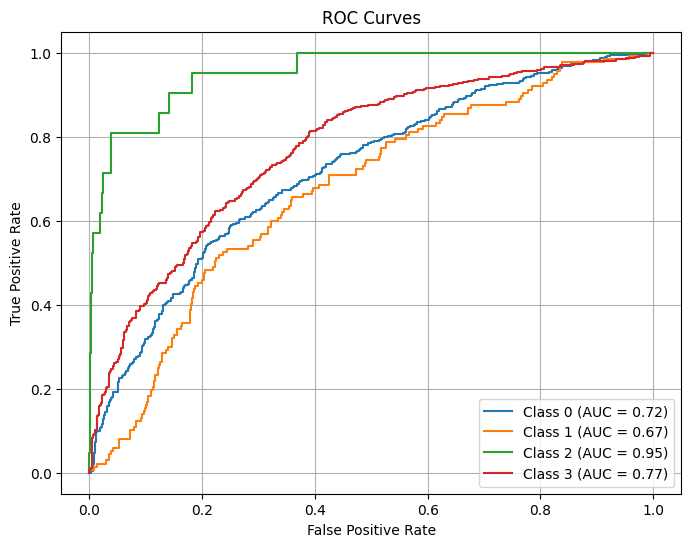

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
y_pred = svm_model.predict(X_val)
y_prob = svm_model.predict_proba(X_val)
class_report = classification_report(y_val, y_pred)
balanced_acc = balanced_accuracy_score(y_val, y_pred)
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2, 3])
roc_auc = roc_auc_score(y_val_binarized, y_prob, average='macro', multi_class='ovr')
print("Classification Report:\n", class_report)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y_val_class = np.argmax(y_val, axis=1)  # Convert one-hot encoded y_val to class labels

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_class = rf_model.predict(X_val)
y_pred_prob = rf_model.predict_proba(X_val)  # Probabilities for ROC curve

# Classification report
class_report = classification_report(y_val_class, y_pred_class)
print("Classification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_val_class, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# ROC AUC score (One-vs-Rest)
roc_auc = roc_auc_score(label_binarize(y_val_class, classes=[0, 1, 2, 3]), y_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(4):  # Four classes
    fpr, tpr, _ = roc_curve(label_binarize(y_val_class, classes=[0, 1, 2, 3])[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74       549
           1       0.42      0.37      0.39       137
           2       0.81      0.62      0.70        21
           3       0.80      0.80      0.80       696

    accuracy                           0.74      1403
   macro avg       0.69      0.64      0.66      1403
weighted avg       0.73      0.74      0.74      1403

Balanced Accuracy: 0.6363
ROC AUC Score: 0.8808


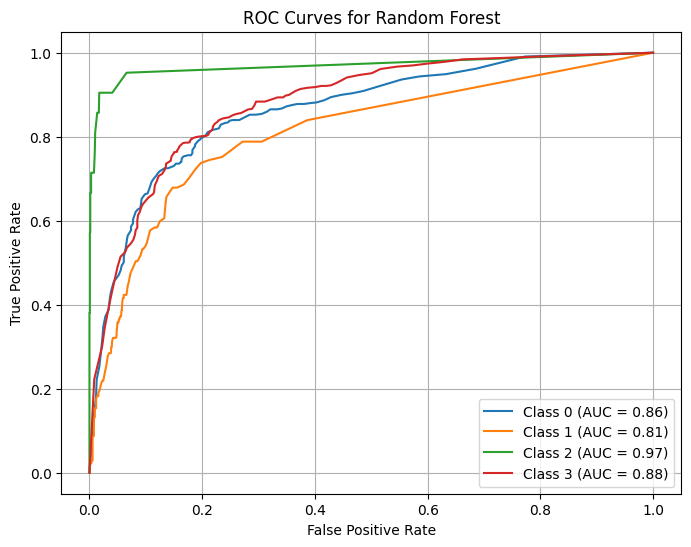

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)
y_prob = rf_model.predict_proba(X_val)

# Binarize the true labels for multi-class ROC AUC calculation
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2, 3])

# Metrics
class_report = classification_report(y_val, y_pred)
balanced_acc = balanced_accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val_binarized, y_prob, average='macro', multi_class='ovr')

# Display metrics
print("Classification Report:\n", class_report)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):  # Assuming 4 classes
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.title("ROC Curves for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
